# Capstone, Part III: Predictive Modeling

## 1. Importing Data & Needed Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns


from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV

%matplotlib inline
plt.style.use("ggplot")

In [2]:
path = "../enem2017/DADOS/final_pima.csv"
valid_pima = pd.read_csv(path, encoding="latin1")
pd.set_option("max_rows", 150)     
pd.set_option("max_columns", 150)

In [3]:
valid_pima.head()

,student_id_num,city_of_residence,state_of_residence,age,sex,marital_status,race,nationality,birth_city_name,birth_state_initials,student_hs_grad_status,high_school_graduation_year,hs_type,for_fun?,pregnant?,requested_resource?,transgender?,did_ns_math?,did_hs_lang?,ns_score,hs_score,lc_score,math_score,for_language_choice,essay_gradable?,essay_score,dad_male_guardian_education,mom_female_guardian_education,male_occupation_class,female_occupation_class,number_of_housemates_include_student,family_monthly_income,domestic_worker?,home_has_bathroom?,home_wash_machine?,home_computer,home_has_internet?,income_avr,per_house_member_income,total_score,combined_score
0,170003336360,Teresina,Piauí,30.0,M,Married,Mestizo,brazilian,Teresina,PI,finished,before_2007,no_response,"no,_student",0,0,0,Present,Present,674.8,682.7,626.4,795.0,English,all_good,780.0,college,high_school,skilled_white5,low_white4,3.0,18740+,Yes,Yes,Yes,3,Yes,18740.0,6246.666667,3558.9,2778.9
1,170001671264,Balsas,Maranhão,25.0,M,Single,Mestizo,brazilian,Balsas,MA,finished,2010,no_response,"no,_student",0,0,0,Present,Present,473.5,594.0,371.1,439.9,English,all_good,560.0,completed_9th,high_school,skilled_blue3,skilled_blue3,3.0,937-1406,No,Yes,Yes,1,Yes,1171.5,390.500000,2438.5,1878.5
2,170001663653,São Luís,Maranhão,23.0,F,Single,White,brazilian,São Luís,MA,finished,2012,no_response,"no,_student",0,0,0,Present,Present,430.6,630.0,549.5,493.9,Spanish,all_good,780.0,fifth_grade,fifth_grade,skilled_blue3,low_white4,4.0,937-1406,No,Yes,No,1,Yes,1171.5,292.875000,2884.0,2104.0
3,170001670032,Teresina,Piauí,34.0,F,Single,Mestizo,brazilian,Teresina,PI,finished,2016,no_response,"no,_student",0,0,0,Present,Present,532.8,487.1,513.8,492.1,Spanish,all_good,520.0,fifth_grade,no_education,farmer1,farmer1,3.0,0-937,No,Yes,No,0,No,468.5,156.166667,2545.8,2025.8
4,170003333636,São Luís,Maranhão,19.0,F,Single,Mestizo,brazilian,São Luís,MA,finished,2015,no_response,"no,_student",0,0,0,Present,Present,412.4,544.0,496.6,372.3,Spanish,all_good,480.0,high_school,high_school,low_white4,unskilled_blue2,4.0,0-937,No,Yes,Yes,0,Yes,468.5,117.125000,2305.3,1825.3


## 2. Formatting Data for Modeling...

In [4]:
valid_pima["combined_score_level"] = "Unfilled"

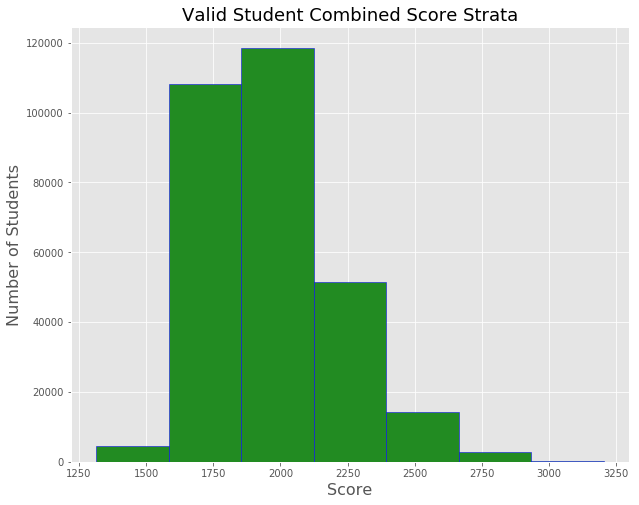

In [5]:
valid_pima["combined_score"].plot(kind="hist", bins=7, edgecolor="blue", color="forestgreen", figsize=(10,8))
plt.ylabel("Number of Students", size=16)
plt.xlabel("Score", size=16)
plt.xticks(rotation=0)
plt.title("Valid Student Combined Score Strata", size=18);

In [6]:
valid_pima.loc[(valid_pima["combined_score"]>= 0) & (valid_pima["combined_score"] <1600), "combined_score_level"] = "Poor"
valid_pima.loc[(valid_pima["combined_score"]>= 1600) & (valid_pima["combined_score"] <1975), "combined_score_level"] = "Fair"
valid_pima.loc[(valid_pima["combined_score"]>= 1975) & (valid_pima["combined_score"] <2250), "combined_score_level"] = "Good"
valid_pima.loc[(valid_pima["combined_score"]>= 2250) & (valid_pima["combined_score"] <2550), "combined_score_level"] = "Excellent"
valid_pima.loc[(valid_pima["combined_score"]>= 2550) & (valid_pima["combined_score"] <3300), "combined_score_level"] = "Superior"

In [7]:
valid_pima["combined_score_level"] = valid_pima["combined_score_level"].map({"Poor":0, "Fair":1, "Good":2,
                "Excellent":3, "Superior":4})

## Dummifying Time!

In [8]:
sex_dummies = pd.get_dummies(valid_pima["sex"], prefix="sex", drop_first=True)
marriage_dummies = pd.get_dummies(valid_pima["marital_status"], prefix="status", drop_first=True)
race_dummies = pd.get_dummies(valid_pima["race"], prefix="race", drop_first=True)
nationality_dummies = pd.get_dummies(valid_pima["nationality"], prefix="nationality", drop_first=True)
hs_type_dummies = pd.get_dummies(valid_pima["hs_type"], prefix="hs_type", drop_first=True)
grad_status_dummies = pd.get_dummies(valid_pima["student_hs_grad_status"], prefix="grad_status", drop_first=True)
city_dummies = pd.get_dummies(valid_pima["city_of_residence"], prefix="city", drop_first=True)
state_dummies = pd.get_dummies(valid_pima["state_of_residence"], prefix="grad_status", drop_first=True)
grad_year_dummies = pd.get_dummies(valid_pima["high_school_graduation_year"], prefix="year", drop_first=True)


fun_dummies = pd.get_dummies(valid_pima["for_fun?"], prefix="fun", drop_first=True)
resource_dummies = pd.get_dummies(valid_pima["requested_resource?"], prefix="resource", drop_first=True)
essay_dummies = pd.get_dummies(valid_pima["essay_gradable?"], prefix="essay_deal", drop_first=True)

dad_educ_dummies = pd.get_dummies(valid_pima["dad_male_guardian_education"], prefix="dad_educ", drop_first=True)
mom_educ_dummies = pd.get_dummies(valid_pima["mom_female_guardian_education"], prefix="mom_educ", drop_first=True)
fam_income_dummies = pd.get_dummies(valid_pima["family_monthly_income"], prefix="income", drop_first=True)
nanny_dummies = pd.get_dummies(valid_pima["domestic_worker?"], prefix="nanny", drop_first=True)
internet_dummies = pd.get_dummies(valid_pima["home_has_internet?"], prefix="internet", drop_first=True)
computer_dummies = pd.get_dummies(valid_pima["home_computer"], prefix="computer", drop_first=True)
wash_dummies = pd.get_dummies(valid_pima["home_wash_machine?"], prefix="wash_machine", drop_first=True)
language_dummies = pd.get_dummies(valid_pima["for_language_choice"], prefix="language", drop_first=True)

In [9]:
valid_pima.drop(["sex","marital_status", "race", "nationality", "hs_type", "student_hs_grad_status",
                 "city_of_residence", "state_of_residence", "high_school_graduation_year", "hs_type",
                 "for_fun?", "requested_resource?", "essay_gradable?", "dad_male_guardian_education",
                 "mom_female_guardian_education","family_monthly_income", "domestic_worker?", "home_has_internet?", 
                 "home_computer", "home_wash_machine?", "for_language_choice" ], axis=1, inplace=True)

In [10]:
valid_pima = pd.concat([valid_pima, sex_dummies, marriage_dummies,race_dummies, nationality_dummies, hs_type_dummies,
                        grad_status_dummies,city_dummies, state_dummies, grad_year_dummies, fun_dummies,
                        resource_dummies, essay_dummies, dad_educ_dummies, mom_educ_dummies, fam_income_dummies,
                        nanny_dummies, internet_dummies, computer_dummies,wash_dummies, language_dummies], axis=1)

In [11]:
feature_cols = ["age","per_house_member_income","sex_M","race_Black","race_Mestizo","race_Native","race_White","dad_educ_college","dad_educ_completed_9th",
        "dad_educ_don't_know","dad_educ_fifth_grade","dad_educ_graduate_degree","dad_educ_high_school","dad_educ_no_education",
        "nanny_Yes","internet_Yes","computer_1","wash_machine_Yes","language_Spanish"]

feature_cols2 = ["race_Mestizo", "dad_educ_fifth_grade", "computer_1","language_Spanish"]

feature_cols1 = [
    
"age","per_house_member_income","number_of_housemates_include_student",
"income_avr","per_house_member_income",
"sex_M","status_Married","status_Missing","status_Single","status_Widow(er)","race_Black","race_Mestizo","race_Native",
"race_White","race_no_response","nationality_foreigner","nationality_native_born_abroad","nationality_naturalized",
"nationality_no_response","hs_type_no_response","hs_type_private","hs_type_public","grad_status_finished",
"grad_status_finishing_after_2017","grad_status_finishing_in_2017","grad_status_Piauí","year_2008","year_2009","year_2010",
"year_2011","year_2012","year_2013","year_2014","year_2015","year_2016","year_before_2007","year_no_response","fun_yes_not_student",
"resource_1","essay_deal_2.0","essay_deal_3.0","essay_deal_4.0","essay_deal_6.0","essay_deal_7.0","essay_deal_8.0","essay_deal_9.0",
"dad_educ_college","dad_educ_completed_9th","dad_educ_don't_know","dad_educ_fifth_grade","dad_educ_graduate_degree","dad_educ_high_school",
"dad_educ_no_education","mom_educ_college","mom_educ_completed_9th","mom_educ_don't_know","mom_educ_fifth_grade","mom_educ_graduate_degree",
"mom_educ_high_school","mom_educ_no_education","income_11244-14055","income_14055-18740","income_1406-1874","income_1874-2343",
"income_18740+","income_2343-2811","income_2811-3748","income_3748-4685","income_4685-5622","income_5622-6559","income_6559-7496",
"income_7496-8433","income_8433-9370","income_937-1406","income_9730-11244","income_no_response","nanny_Yes","internet_Yes",
"computer_1","computer_2","computer_3","computer_4","wash_machine_Yes","language_Spanish"]


#"male_occupation_class", "home_has_bathroom?"
#"female_occupation_class"

In [12]:
X = valid_pima[feature_cols]
y = valid_pima["combined_score_level"]

## Baseline

In [13]:
valid_pima["combined_score_level"].value_counts(normalize=True)

1    0.560148
2    0.292282
3    0.103846
4    0.022727
0    0.020998
Name: combined_score_level, dtype: float64

In [14]:
# valid_pima.describe()

_Ideally, we want to have a model that has greater accuracy than 56%, the accuracy we would have just by guessing._

## Model 1: Random Forest Classifier

In [15]:
len(feature_cols)
np.sqrt(len(feature_cols))

4.358898943540674

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12345)

In [17]:
rfclass = RandomForestClassifier(n_estimators=500, max_features=5, oob_score=True, random_state=12345, n_jobs=10)

In [18]:
rfclass.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=10,
            oob_score=True, random_state=12345, verbose=0,
            warm_start=False)

#### Looking at Feature Importance

In [19]:
pd.DataFrame({"feature": feature_cols, "importance":rfclass.feature_importances_}).sort_values(by="importance", ascending=False).head(10)


,feature,importance
0,age,0.382404
1,per_house_member_income,0.357579
15,internet_Yes,0.029295
17,wash_machine_Yes,0.028294
16,computer_1,0.026386
2,sex_M,0.019896
4,race_Mestizo,0.018509
18,language_Spanish,0.017406
3,race_Black,0.015280
6,race_White,0.015020


_These are the top 10 most influential features in the model._ 

In [20]:
rfclass.oob_score_  

0.535690172876357

_The OOB score is less than guessing, which is bad. This model is probably not the best fit._ 

_Thought about trying to tune, so that work is here._

In [21]:
# kfforest = KFold(n_splits=5, shuffle=True)
# scores = cross_val_score(rfclass, X, y, cv=3, scoring="neg_mean_squared_error")
# np.mean(np.sqrt(-scores))

# #This is the average RMSE 

# #Tuning n_Estimators

# estimator_range = range(10, 200, 5)
# RMSE_scores = []

# for estimator in estimator_range:
#     tune_rfclass = RandomForestClassifier(n_estimators=estimator, random_state=12345)
#     MSE_scores = cross_val_score(tune_rfclass, X, y, cv=3, scoring="neg_mean_squared_error")
#     RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

# plt.plot(estimator_range, RMSE_scores);

# rfc = RandomForestClassifier()
# rfe = RFECV(estimator=rfc, cv=kfforest)

# rfe.fit(X,y)

# X_rfe = rfe.transform(X)

# X_rfe.shape
# rfe.support_ #Based on this it is the second feature: per_house_member_income 

## Model 2: K Nearest Neighbors Classifier

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=12345)

In [23]:
ss = StandardScaler()
ss.fit(X_train)
X_ss = ss.transform(X_train)

ss.fit(X_test)
X_ss_test = ss.transform(X_test)

C:\Users\602770\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\602770\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\602770\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\602770\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  


In [24]:
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=10)
knn.fit(X_ss, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=10, n_neighbors=5, p=2,
           weights='uniform')

In [25]:
knn.score(X_ss_test, y_test)

0.5421352806353605

_The classification model didn't do well either, still less accuracy than guessing._ 

_To find the ideal number of k neighbors, the algorithm below would work._

In [26]:
# knearest = KFold(n_splits=5, shuffle=True)

# k_range = range(1, 101)

# train_error = []
# test_error = []

# for k in k_range:
#     t_knn = KNeighborsClassifier(n_neighbors=k, n_jobs=10)
#     t_knn.fit(X_train, y_train)
    
#     train_accuracy_score = t_knn.score(X_train, y_train)

#     #np.mean(cross_val_score(test_knn, X_ss, y, cv=knearest))
#     train_error.append(1 - train_accuracy_score)
    
#     test_accuracy_score = t_knn.score(X_test, y_test)
#     test_error.append((1 - test_accuracy_score))
    
# cols_dict = {"k": k_range, "Train Error": train_error, "Test Error": test_error}
# lets_see = pd.DataFrame(cols_dict).set_index("k")

# let_see.head(10)

## Model 3: Bagged Decision Tree 

In [27]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12345)

In [28]:
treeclf = DecisionTreeClassifier(max_features=5, random_state=12345)

bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, bootstrap=True,
                       oob_score=True, random_state=12345)

In [29]:
bag.fit(X_train, y_train)
y_pred = bag.predict(X_test)

In [30]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

0.8739518915517425

In [31]:
bag.oob_score_

0.536671819199403

_This did not perform better than guessing either. 

## Model 4: Logistic Regression Classifier 

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=12345)

lmr = LogisticRegression(C=1e9, multi_class="multinomial", solver="saga")

lmr.fit(X_train,y_train)

pred = lmr.predict(X_test)

C:\Users\602770\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [33]:
# metrics.mean_absolute_error(y_test, pred)
print(metrics.confusion_matrix(y_test, pred))

[[    0  1536    26     1     0]
 [    0 39981  1638   220     5]
 [    0 19423  2226   522     9]
 [    0  5205  1816   675    24]
 [    0   567   676   482    12]]


In [34]:
metrics.accuracy_score(y_test, pred)

0.5715846703267417

_So multinomial logistic regression does marginally better than guessing, by about 1%._

_Now, we'll use kfolds cross validation to improve the score._

In [35]:
kf = KFold(n_splits=5, shuffle=True)
lmr = LogisticRegression(C=1e9, multi_class="multinomial", solver="saga")

np.mean(cross_val_score(lmr, X, y, cv=kf))

C:\Users\602770\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\602770\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\602770\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\602770\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\602770\AppData\Local\Continuum\anaconda3\li

0.5744596510187499

_Using kfold valdiation has helped marginally._

## RFE 

_There are many different x variables, so we will run recursive feature elimination to try to pinpoint the most influential x variables in our model._

In [36]:
lc = LogisticRegression(C=1e9, multi_class="multinomial", solver="saga")
kfff = KFold(n_splits=5, shuffle=True)
rfe = RFECV(estimator=lc, cv=kfff)

In [37]:
rfe.fit(X,y)
X_rfe = rfe.transform(X)

C:\Users\602770\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\602770\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\602770\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\602770\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\602770\AppData\Local\Continuum\anaconda3\li

C:\Users\602770\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\602770\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\602770\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\602770\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\602770\AppData\Local\Continuum\anaconda3\li

C:\Users\602770\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\602770\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\602770\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\602770\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\602770\AppData\Local\Continuum\anaconda3\li

In [38]:
X_rfe.shape

(300176, 8)

In [39]:
rfe.support_

array([ True,  True,  True, False,  True, False, False, False, False,
       False,  True, False, False, False, False,  True,  True, False,
        True])

In [40]:
X = valid_pima[feature_cols2]
y = valid_pima["combined_score_level"]

In [41]:
kf = KFold(n_splits=5, shuffle=True)
lmr = LogisticRegression(C=1e9, multi_class="multinomial", solver="saga")

np.mean(cross_val_score(lmr, X, y, cv=kf))

0.5656048540166037

_So it turns out doing RFE wasn't actually that helpful in improving the model._

## Model 5: Linear Regression

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.25, train_size=.75, random_state=12345)
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [43]:
y_null = np.ones_like(y_test) * np.mean(y_train)
np.sqrt(metrics.mean_squared_error(y_test, y_null)) #Null RMSE 

0.796116739711319

In [44]:
y_pred = lr.predict(X_test)
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

0.7609933909678454

In [45]:
lr.score(X_test,y_test)

0.0862707036202659

_Even a linear regression does little to decrease the Null RMSE with the given model._